In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Cài đặt 
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
import pandas as pd

df01 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_april.csv')
df02 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_october.csv')

# Ghép 2 file lại với nhau
data_filled = pd.concat([df01, df02], ignore_index=True)

# 1. Xử lý dữ liệu bị thiếu

In [3]:
# df_cleaned = data.copy()
# df_cleaned = df_cleaned.drop(columns=['B04B', 'B05B', 'B06B', 'VSB', 'CIN'])

# df_cleaned = df_cleaned[~((df_cleaned['AWS'] == -np.inf) | (df_cleaned['AWS'].isnull()))]
# df_cleaned = df_cleaned[~((df_cleaned['SLHF'] == 9999) | (df_cleaned['SSHF'] == 9999))]

In [4]:
# data_filled = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

# 2. Chia train test

In [5]:
def split_data_by_multiple_ranges(df, train_ranges):
    train_mask = False
    for start, end in train_ranges:
        train_mask |= (df['datetime'] >= start) & (df['datetime'] < end)
    train_df = df[train_mask]
    test_df = df[~train_mask]
    return train_df, test_df

def convert_rain_label(df):
    df['AWS'] = df['AWS'].apply(lambda x: 1 if x > 0 else 0)
    return df

# Gắn nhãn
df_all1 = convert_rain_label(data_filled)

# Chuyển datetime nếu chưa
df_all1['datetime'] = pd.to_datetime(df_all1['datetime'])

# Chọn các khoảng train: tháng 4/2019, 10/2019, 4/2020
train_ranges = [
    ("2019-04-01", "2019-04-30"),
    ("2019-10-01", "2019-10-31"),
    ("2020-04-01", "2020-04-30"),
]

# Tách train/test theo mốc trên
train_df, test_df = split_data_by_multiple_ranges(df_all1, train_ranges)

# Giữ lại chỉ test tháng 10/2020
test_df = test_df[
    (test_df['datetime'] >= "2020-10-01") & (test_df['datetime'] <= "2020-10-31")
]

# Kết quả
print(f"Train set: {train_df.shape}")
print(f"Test set (October 2020): {test_df.shape}")

Train set: (428242, 33)
Test set (October 2020): (207094, 33)


In [6]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# 3. Chuẩn hóa

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 4. Chọn feature

In [8]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

In [9]:
# X_train_selected = X_train_scaled[top_features]
# X_test_selected = X_test_scaled[top_features]

In [10]:
#Performance evaluation
def print_scores(y_true, y_pred):
  print(classification_report(y_true, y_pred))

# 5. Implement PNN

In [11]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [12]:
from sklearn.metrics import pairwise_distances

class RBFLayer:
    def __init__(self, centers, sigma=1.0):
        self.centers = centers
        self.sigma = sigma

    def compute(self, X):
        diff = X[:, np.newaxis, :] - self.centers
        dist_sq = np.sum(diff**2, axis=2)
        return np.exp(-dist_sq / (2 * self.sigma**2))

def softmax(z):
    # z: (n_samples, n_classes)
    z_max = np.max(z, axis=1, keepdims=True)
    e_z = np.exp(z - z_max)
    return e_z / e_z.sum(axis=1, keepdims=True)

#Define PNN Model
class PNN:
    def __init__(self, sigma=1.0, batch_size=1000):
        self.sigma = sigma
        self.centers = None
        self.batch_size = batch_size

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        else:
            X_train = X_train
        if isinstance(y_train, pd.Series):
            y_train = y_train.values
        else:
            y_train = y_train

        classes = np.unique(y_train)
        centers = []
        for c in classes:
            centers.append(X_train[y_train == c].mean(axis=0))
        self.centers = np.vstack(centers)
        self.rbf = RBFLayer(self.centers, sigma=self.sigma)

    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        else:
            X = X
            
        n = X.shape[0]
        if self.batch_size is None:
            raw = self.rbf.compute(X)
            return softmax(raw)
        # batch processing
        probs = []
        for start in range(0, n, self.batch_size):
            end = min(start + self.batch_size, n)
            raw = self.rbf.compute(X[start:end])
            probs.append(softmax(raw))
        return np.vstack(probs)

    def predict(self, X):
        # trả về nhãn 0 hoặc 1
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

In [13]:
models_info = [
    ("Tháng 4 + 10", X_train_scaled, y_train, X_test_scaled, y_test),
]


Fine tuning...
Tháng 4 + 10...
Best sigma: 1.3894954943731375 with f1: 0.6018785176100467
Train with best param...
Tháng 4 + 10...
(428242, 29)
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.53      0.69    159566
           1       0.37      0.94      0.53     47528

    accuracy                           0.63    207094
   macro avg       0.67      0.73      0.61    207094
weighted avg       0.83      0.63      0.65    207094

Confusion Matrix:
[[85192 74374]
 [ 3050 44478]]


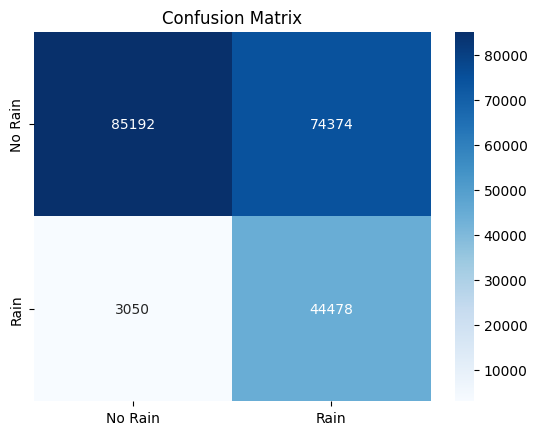

In [14]:
#Fine-tune + train
sigmas = np.logspace(-2, 1, 50)
param_grid = {'sigma': sigmas.tolist()}  # Grid search for sigma values

best_score = 0
best_sigma = 0

# Perform grid search over the values of sigma
print("Fine tuning...")
for name, train_X, train_Y, X_test, y_test in models_info:
    X_train, X_val, y_train, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, random_state=42
    )
    print(f"{name}...")
    for sigma in param_grid['sigma']:
        pnn_batch = PNN(sigma=sigma, batch_size=2048)
        pnn_batch.fit(X_train, y_train)
        y_pred = pnn_batch.predict(X_val)
        score = classification_report(y_val, y_pred, zero_division=0, output_dict=True)['macro avg']['f1-score']
    
        if score > best_score:
            best_score = score
            best_sigma = sigma

    print(f"Best sigma: {best_sigma} with f1: {best_score}")

# Final evaluation with the best sigma
print("Train with best param...")
for name, X_train, y_train, X_test, y_test in models_info:
    print(f"{name}...")
    print(X_train.shape)
    pnn_batch = PNN(sigma=best_sigma, batch_size=1000)
    pnn_batch.fit(X_train, y_train)
    y_pred = pnn_batch.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Optionally, plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
    plt.title("Confusion Matrix")
    plt.show()

Fine tuning...
Tháng 4 + 10...
Best sigma: 1.0481131341546852 with f1: 0.6080966341506577
Train with best param...
Tháng 4 + 10...
(428242, 29)
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.45      0.62    159566
           1       0.35      0.98      0.51     47528

    accuracy                           0.57    207094
   macro avg       0.67      0.72      0.57    207094
weighted avg       0.84      0.57      0.60    207094

Confusion Matrix:
[[72147 87419]
 [  934 46594]]


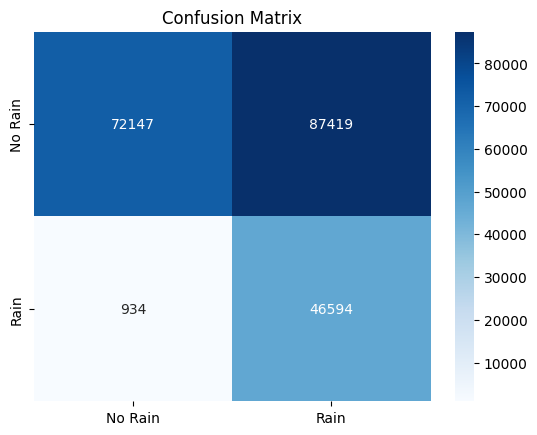

In [15]:
#Fine-tune + train
sigmas = np.logspace(-2, 1, 50)
param_grid = {'sigma': sigmas.tolist()}  # Grid search for sigma values

best_score = 0
best_sigma = 0

# Perform grid search over the values of sigma
print("Fine tuning...")
for name, train_X, train_Y, X_test, y_test in models_info:
    train_X = train_X[top_features]
    X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, random_state=42
    )
    print(f"{name}...")
    for sigma in param_grid['sigma']:
        pnn_batch = PNN(sigma=sigma, batch_size=2048)
        pnn_batch.fit(X_train, y_train)
        y_pred = pnn_batch.predict(X_val)
        score = classification_report(y_val, y_pred, zero_division=0, output_dict=True)['macro avg']['f1-score']
    
        if score > best_score:
            best_score = score
            best_sigma = sigma

    print(f"Best sigma: {best_sigma} with f1: {best_score}")

# Final evaluation with the best sigma
print("Train with best param...")
for name, X_train, y_train, X_test, y_test in models_info:
    print(f"{name}...")
    print(X_train.shape)
    X_train = X_train[top_features]
    X_test = X_test[top_features]
    pnn_batch = PNN(sigma=best_sigma, batch_size=1000)
    pnn_batch.fit(X_train, y_train)
    y_pred = pnn_batch.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Optionally, plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
    plt.title("Confusion Matrix")
    plt.show()

# 6. Cân bằng dữ liệu (Oversampling)

## 6.1 SMOTE

In [16]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [17]:
models_info = [
    ("Tháng 4 + 10 smote", X_train_scaled, y_sm, X_test_scaled, y_test),
]


Fine tuning...
Tháng 4 + 10 smote...
Best sigma: 1.5998587196060574 with f1: 0.75511401006523
Train with best param...
Tháng 4 + 10 smote...
(786988, 15)
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.40      0.57    159566
           1       0.33      0.99      0.49     47528

    accuracy                           0.53    207094
   macro avg       0.66      0.69      0.53    207094
weighted avg       0.84      0.53      0.55    207094

Confusion Matrix:
[[63234 96332]
 [  623 46905]]


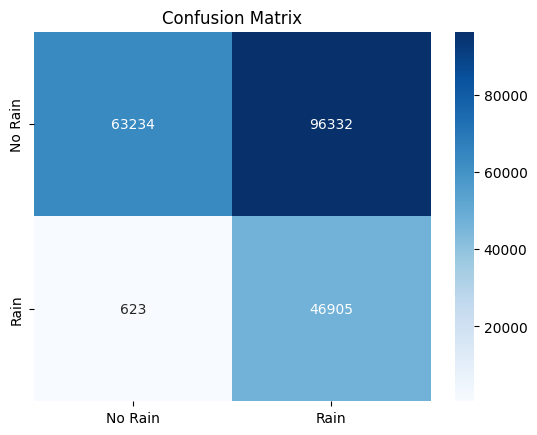

In [18]:
#Fine-tune + train
sigmas = np.logspace(-2, 1, 50)
param_grid = {'sigma': sigmas.tolist()}  # Grid search for sigma values

best_score = 0
best_sigma = 0

# Perform grid search over the values of sigma
print("Fine tuning...")
for name, train_X, train_Y, X_test, y_test in models_info:
    X_train, X_val, y_train, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, random_state=42
    )
    print(f"{name}...")
    for sigma in param_grid['sigma']:
        pnn_batch = PNN(sigma=sigma, batch_size=2048)
        pnn_batch.fit(X_train, y_train)
        y_pred = pnn_batch.predict(X_val)
        score = classification_report(y_val, y_pred, zero_division=0, output_dict=True)['macro avg']['f1-score']
    
        if score > best_score:
            best_score = score
            best_sigma = sigma

    print(f"Best sigma: {best_sigma} with f1: {best_score}")

# Final evaluation with the best sigma
print("Train with best param...")
for name, X_train, y_train, X_test, y_test in models_info:
    print(f"{name}...")
    print(X_train.shape)
    pnn_batch = PNN(sigma=best_sigma, batch_size=1000)
    pnn_batch.fit(X_train, y_train)
    y_pred = pnn_batch.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Optionally, plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
    plt.title("Confusion Matrix")
    plt.show()

Fine tuning...
Tháng 4 + 10 smote...
Best sigma: 1.5998587196060574 with f1: 0.75511401006523
Train with best param...
Tháng 4 + 10 smote...
(786988, 15)
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.40      0.57    159566
           1       0.33      0.99      0.49     47528

    accuracy                           0.53    207094
   macro avg       0.66      0.69      0.53    207094
weighted avg       0.84      0.53      0.55    207094

Confusion Matrix:
[[63234 96332]
 [  623 46905]]


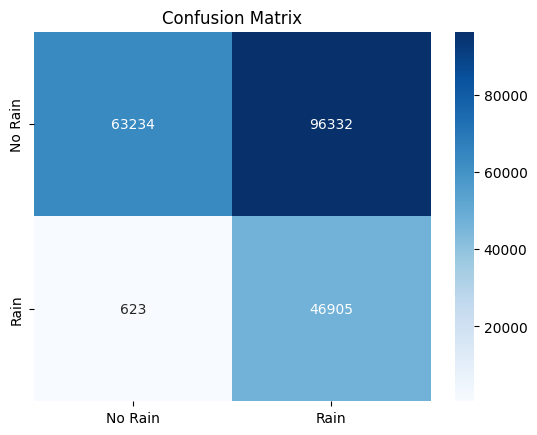

In [19]:
#Fine-tune + train
sigmas = np.logspace(-2, 1, 50)
param_grid = {'sigma': sigmas.tolist()}  # Grid search for sigma values

best_score = 0
best_sigma = 0

# Perform grid search over the values of sigma
print("Fine tuning...")
for name, train_X, train_Y, X_test, y_test in models_info:
    train_X = train_X[top_features]
    X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, random_state=42
    )
    print(f"{name}...")
    for sigma in param_grid['sigma']:
        pnn_batch = PNN(sigma=sigma, batch_size=2048)
        pnn_batch.fit(X_train, y_train)
        y_pred = pnn_batch.predict(X_val)
        score = classification_report(y_val, y_pred, zero_division=0, output_dict=True)['macro avg']['f1-score']
    
        if score > best_score:
            best_score = score
            best_sigma = sigma

    print(f"Best sigma: {best_sigma} with f1: {best_score}")

# Final evaluation with the best sigma
print("Train with best param...")
for name, X_train, y_train, X_test, y_test in models_info:
    print(f"{name}...")
    print(X_train.shape)
    X_train = X_train[top_features]
    X_test = X_test[top_features]
    pnn_batch = PNN(sigma=best_sigma, batch_size=1000)
    pnn_batch.fit(X_train, y_train)
    y_pred = pnn_batch.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Optionally, plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
    plt.title("Confusion Matrix")
    plt.show()

## 6.2 SMOTE ENN

In [20]:
# SMOTE ENN
from imblearn.combine import SMOTEENN

smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [21]:
models_info = [
    ("Tháng 4 + 10 smoteenn", X_train_scaled, y_smenn, X_test_scaled, y_test),
]


Fine tuning...
Tháng 4 + 10 smoteenn...
Best sigma: 1.5998587196060574 with f1: 0.7874994438807961
Train with best param...
Tháng 4 + 10 smoteenn...
(704873, 15)
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.39      0.56    159566
           1       0.32      0.99      0.49     47528

    accuracy                           0.52    207094
   macro avg       0.66      0.69      0.52    207094
weighted avg       0.84      0.52      0.54    207094

Confusion Matrix:
[[61761 97805]
 [  593 46935]]


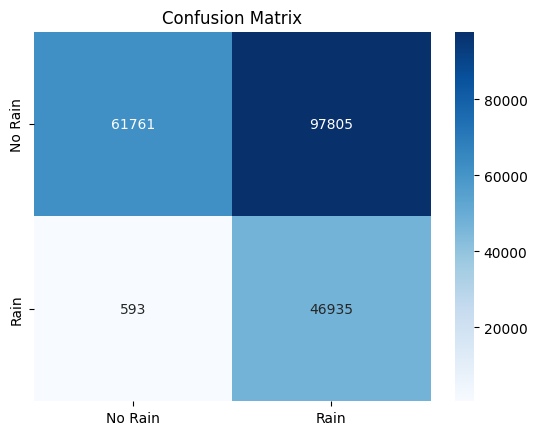

In [22]:
#Fine-tune + train
sigmas = np.logspace(-2, 1, 50)
param_grid = {'sigma': sigmas.tolist()}  # Grid search for sigma values

best_score = 0
best_sigma = 0

# Perform grid search over the values of sigma
print("Fine tuning...")
for name, train_X, train_Y, X_test, y_test in models_info:
    X_train, X_val, y_train, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, random_state=42
    )
    print(f"{name}...")
    for sigma in param_grid['sigma']:
        pnn_batch = PNN(sigma=sigma, batch_size=2048)
        pnn_batch.fit(X_train, y_train)
        y_pred = pnn_batch.predict(X_val)
        score = classification_report(y_val, y_pred, zero_division=0, output_dict=True)['macro avg']['f1-score']
    
        if score > best_score:
            best_score = score
            best_sigma = sigma

    print(f"Best sigma: {best_sigma} with f1: {best_score}")

# Final evaluation with the best sigma
print("Train with best param...")
for name, X_train, y_train, X_test, y_test in models_info:
    print(f"{name}...")
    print(X_train.shape)
    pnn_batch = PNN(sigma=best_sigma, batch_size=1000)
    pnn_batch.fit(X_train, y_train)
    y_pred = pnn_batch.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Optionally, plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
    plt.title("Confusion Matrix")
    plt.show()

Fine tuning...
Tháng 4 + 10 smoteenn...
Best sigma: 1.5998587196060574 with f1: 0.7874994438807961
Train with best param...
Tháng 4 + 10 smoteenn...
(704873, 15)
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.39      0.56    159566
           1       0.32      0.99      0.49     47528

    accuracy                           0.52    207094
   macro avg       0.66      0.69      0.52    207094
weighted avg       0.84      0.52      0.54    207094

Confusion Matrix:
[[61761 97805]
 [  593 46935]]


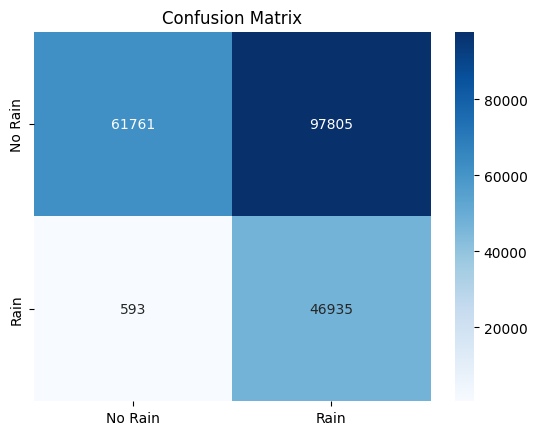

In [23]:
#Fine-tune + train
sigmas = np.logspace(-2, 1, 50)
param_grid = {'sigma': sigmas.tolist()}  # Grid search for sigma values

best_score = 0
best_sigma = 0

# Perform grid search over the values of sigma
print("Fine tuning...")
for name, train_X, train_Y, X_test, y_test in models_info:
    train_X = train_X[top_features]
    X_test = X_test[top_features]
    X_train, X_val, y_train, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, random_state=42
    )
    print(f"{name}...")
    for sigma in param_grid['sigma']:
        pnn_batch = PNN(sigma=sigma, batch_size=2048)
        pnn_batch.fit(X_train, y_train)
        y_pred = pnn_batch.predict(X_val)
        score = classification_report(y_val, y_pred, zero_division=0, output_dict=True)['macro avg']['f1-score']
    
        if score > best_score:
            best_score = score
            best_sigma = sigma

    print(f"Best sigma: {best_sigma} with f1: {best_score}")

# Final evaluation with the best sigma
print("Train with best param...")
for name, X_train, y_train, X_test, y_test in models_info:
    print(f"{name}...")
    print(X_train.shape)
    X_train = X_train[top_features]
    X_test = X_test[top_features]
    pnn_batch = PNN(sigma=best_sigma, batch_size=1000)
    pnn_batch.fit(X_train, y_train)
    y_pred = pnn_batch.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Optionally, plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
    plt.title("Confusion Matrix")
    plt.show()

# 7. Kết luận

- PNN hoạt động tốt khi không chọn lọc đặc trưng hơn
- Kết quả cao hơn so với chia theo thời gian riêng từng bộ
- Kết quả tốt nhất khi không oversampling, lấy tất cả các đặc trưng => Khả năng học của PNN không bị phụ thuộc bởi việc tăng thêm nhiều dữ liệu